(C) Gerold Baier, University College London, 2025

# Single Oscillator


## The two-variable neural population oscillator

The two populations' temporal dynamics (change of state) is described by two first-order nonlinear differential equations:

$$ \frac{dEx}{dt} = h_{ex} - Ex + c_1*sigmoid(Ex) - c_2*sigmoid(In) + pert$$
$$ \frac{dIn}{dt} \,\, = h_{in} \,\, - In \, + c_3*sigmoid(Ex) - c_4*sigmoid(In)) $$

$Ex$ and $In$ are variables that change over time $t$ and represent the excitatory and inhibitory neural population, respectively.

$h_{ex}$, $h_{in}$, $c_1$, $c_2$, $c_3$ and $c_4$ are model parameters representing constant input ($h_i$) and strength of (self-)coupling ($c_j$), respectively. 

Function _sigmoid_ is the continuous step function, conmputationally implemented as tangens hyperbolicus.

_pert_ represents an additive external perturbation and is implemented as either a single rectangular step or a periodic series of rectangular steps. 


- Time series
- Bifurcation diagram as a function of parameter h_ex
- Simulated seizure onset with ramp inparameter h_ex
- Scan of initial conditions in the excitable (preseizure) state
- Scan of parameters of single pulse perturbation
- Scan of frequency of periodic pulse perturbation


## Import Functions

In [101]:
from scipy.integrate import odeint

from scipy.signal import find_peaks

from numpy import zeros, ones, tanh, mod, linspace
from numpy import fill_diagonal, ndarray, amax, amin
from numpy import asarray, array, around, arange, corrcoef, flip, var, append
from numpy.random import default_rng

from matplotlib.pyplot import subplots

import sk_dsp_comm.sigsys as ss

from itertools import product


## Model and Functions

In [104]:
def sigmoid(u):
    return tanh(u)

def single_oscillator(y, t, N, h_ex, h_in, pars, frac_E, frac_I, sr, time_stop, pulse):

    tau_ex, tau_in, c2, c4, c_EE, c_EI = pars

    dydt = (   
        (h_ex - y[0] - c2*sigmoid(y[1]) + c_EE*sigmoid(y[0]))*tau_ex,
         
        (h_in - y[1] - c4*sigmoid(y[1]) + c_EI*sigmoid(y[0]))*tau_in,    
            )

    return dydt

def single_oscillator_plus_driving(y, t, h_ex, h_in, pars, sr, time_stop, driving, driving_strength):

    tau_ex, tau_in, c1, c2, c3, c4 = pars
    
    index = int(t*sr)
    
    if index >= time_stop*sr:
    
        dydt = zeros(2)
        
        return dydt
    
    h_ex_driven = h_ex + driving_strength*driving[index]

    dydt = (
        (h_ex_driven - y[0] + c1*sigmoid(y[0]) - c2*sigmoid(y[1]))*tau_ex,
        (h_in        - y[1] + c3*sigmoid(y[0]) - c4*sigmoid(y[1]))*tau_in,
   )

    return dydt

def single_oscillator_pert(y, t, h_ex_p, h_in, pars, sr, time_stop):

    tau_ex, tau_in, c1, c2, c3, c4 = pars

    h_ex_index = int(t*sr)
    
    if h_ex_index >= time_stop*sr:

        dydt = zeros(2)
        
        return dydt
    
    dydt = (
        (h_ex_p[h_ex_index] - y[0] + c1*sigmoid(y[0]) - c2*sigmoid(y[1]))*tau_ex,
        (h_in               - y[1] + c3*sigmoid(y[0]) - c4*sigmoid(y[1]))*tau_in,
       )

    return dydt


In [106]:
def plot_series(time, data, time_begin, time_end, sr):

    fig, ax = subplots(figsize=(4, 3))

    ax.plot(time[time_begin*sr:time_end*sr], data[time_begin*sr:time_end*sr, 0], linewidth=2, c='b')
    ax.set_xticks(linspace(0, time_end-time_begin, 5));
    ax.set_xticklabels(linspace(0, time_end-time_begin, 5));
    ax.set_xlabel('Time', fontsize=12);
    ax.set_ylabel('Ex', fontsize=12)
    y_min, y_max = ax.get_ylim()
    ax.set_yticks(linspace(y_min, y_max, 3));
    ax.set_yticklabels(around(linspace(y_min, y_max, 3),1), fontsize=14);

    fig.tight_layout()
    
    return fig, ax


In [108]:
def plot_bifdiagram(results_min_f, results_max_f, 
                    results_min_b, results_max_b,
                    par_set):
    
    N = len(results_min_f)

    fig, ax = subplots(figsize=(4, 2.5))

    for xe, ye in zip(par_set, results_max_f[0]):

        if not isinstance(ye, ndarray):
            ax.scatter(xe, ye, c='k', s=20, marker='+')
        else:
            ax.scatter([xe] * len(ye), ye, c='b', s=20, marker='o')

    for xe, ye in zip(par_set, results_min_f[0]):

        if not isinstance(ye, ndarray):
            ax.scatter(xe, ye, c='k', s=20, marker='+')
        else:
            ax.scatter([xe] * len(ye), ye, c='b', s=20, marker='o')

    for xe, ye in zip(flip(par_set), results_max_b[0]):

        if not isinstance(ye, ndarray):
            ax.scatter(xe, ye, c='k', s=20, marker='+')
        else:
            ax.scatter([xe] * len(ye), ye, c='b', s=20, marker='o')

    for xe, ye in zip(flip(par_set), results_min_b[0]):

        if not isinstance(ye, ndarray):
            ax.scatter(xe, ye, c='k', s=20, marker='+')
        else:
            ax.scatter([xe] * len(ye), ye, c='b', s=20, marker='o')

    ax.set_xticks(linspace(par_min, par_max, 3));
    ax.set_xticklabels(around(linspace(par_min, par_max, 3), 2), fontsize=16);
    ax.set_xlabel('Parameter', fontsize=16)

    ax.set_ylabel('Ex', fontsize=14)

    y_min, y_max = ax.get_ylim()

    ax.set_yticks(linspace(y_min, y_max, 3));
    ax.set_yticklabels(around(linspace(y_min, y_max, 3),2), fontsize=14);


    fig.tight_layout()
    
    return fig, ax

def plot_bifdiagram_freq(results, freq_set):

    no_scans = len(results)

    if freq_set[-1] < freq_set[0]:
        
        freq_set = flip(freq_set)

    freq_min, freq_max = freq_set[0], freq_set[-1]

    fig, ax  = subplots(nrows=no_scans, figsize=(5, 4))

    for index, result in enumerate(results):
    
        results_min_f, results_max_f = result[0], result[1] 
     
        for xe, ye in zip(freq_set, results_max_f[0]):
    
            if not isinstance(ye, ndarray):
                ax[index].scatter(xe, ye, c='r', s=5)
            else:
                ax[index].scatter([xe] * len(ye), ye, c='b', s=10, marker='o')
      
        ax[index].set_xticks(linspace(freq_min, freq_max, 5));
        ax[index].set_xticklabels([]);
    
        ax[index].set_ylabel('Ex', fontsize=12)
    
        # y_min, y_max = ax[result].get_ylim()
        y_min, y_max = -4, 4

        ax[index].set_ylim(y_min, y_max)
        ax[index].set_yticks(linspace(y_min, y_max, 3))
        ax[index].set_yticklabels(linspace(y_min, y_max, 3))

    ax[index].set_xticks(linspace(freq_min, freq_max, 3));
    ax[index].set_xticklabels(around(linspace(freq_min, freq_max, 3), 2), fontsize=16);
    
    ax[index].set_xlabel('Parameter', fontsize=12)

    fig.tight_layout()
    
    return fig, ax

## Model Parameters

In [140]:
N = 1

# pars = (1, 2.5, 10, 0, 5, 10) # Homoclinic
pars = (1, 1.5, 10, 0, 5, 10) # SNIC
# tau_ex, tau_in, c2, c4, c_EE, c_EI

# Input parameter
h_ex_0 = -6.9
h_in_0 = -4.0

frac_E, frac_I = 0.0, 0.0 # < 1. 0 means no coupling

pulse = []

if pars[1] == 1.5:

    condition = '_SNIC'

    h_ex_0 = -6.9


elif pars[1] == 2.5:

    condition = '_Homoclinic'

    h_ex_0 = -6.9

# Time array
time_stop = 50
sr        = 1000
time      = linspace(start=0, stop=time_stop, num=time_stop*sr)

# Pick Initial conditions

SEED = 123

rng = default_rng(SEED)

# Initital Conditions
y_ini = rng.normal(size=2)
# y_ini = y[-1, :]


## Time Series


In [143]:
# Simulation
y = odeint(func=single_oscillator, y0=y_ini, t=time, 
          args=(N, h_ex_0, h_in_0, pars, frac_E, frac_I, sr, time_stop, pulse), 
          hmax=0.1)

y_last = y[-1, :]

# Show final values of all variables
print('End of run:', list(around(y_last, 3)))
print('')

End of run: [-1.438, -12.84]



Figs/N=1/Bifs_h_ex_SNIC.png


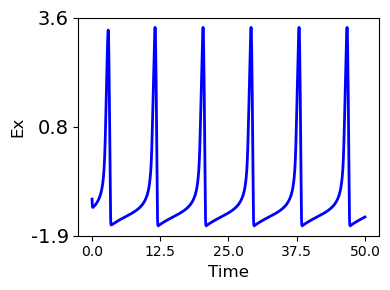

In [145]:
time_begin, time_end = 0, time_stop

fig, ax = plot_series(time, y, time_begin, time_end, sr)
    
title_chars = 'Figs/N=1/Bifs_h_ex' + condition + '.png'

# fig.savefig(title_chars, format='png')

print(title_chars)


"Resonance" here does not search for the internal frequency of the fixed point (if it is a node, there is no internal frequency). Rather, it is a _search in state space_ for any additional structures, in this case cyclical trajectories. 

[Could add a state space plot here]

## Bifurcation Diagram

In [134]:
# Initial conditions
y_ini = y[-1, :]

# Bifurcation parameter range
steps = 30


if pars[1] == 1.5:

    par_min, par_max = -7.5, -6.5


elif pars[1] == 2.5:

    par_min, par_max = -7.5, -6.5
    

par_set = linspace(par_min, par_max, steps)

# Stop time
time_stop = 100
time = linspace(start=0, stop=time_stop, num=time_stop*sr)


results_max_f      = dict()
results_max_inds_f = dict()
results_min_f      = dict()
results_min_inds_f = dict()

rows = time.size

# Simulation "forward"
for par in par_set:
    
    h_ex = par
    
    y_f = odeint(func=single_oscillator, y0=y_ini, t=time, 
             args=(N, h_ex, h_in_0, pars, frac_E, frac_I, sr, time_stop, pulse), 
             hmax=0.1)
 
    for num, series in enumerate(y_f[rows//2:,:-1:2].T):
                
        if var(series) < 0.0005:
            
            if num not in results_max_f:
                
                results_max_f[num]      = [series[-1]]
                results_max_inds_f[num] = [0]    
                results_min_f[num]      = [series[-1]]
                results_min_inds_f[num] = [0]    
                
            else:
                results_max_f[num].append(series[-1])
                results_max_inds_f[num].append(0)    
                results_min_f[num].append(series[-1])
                results_min_inds_f[num].append(0)               


        else:
            y_f_max_inds = find_peaks(series, distance=100)
            y_f_maxs     = series[y_f_max_inds[0]]

            y_f_min_inds = find_peaks(-series, distance=100)
            y_f_mins     = series[y_f_min_inds[0]]

            if num not in results_max_f:

                results_max_f[num]      = [y_f_maxs]
                results_max_inds_f[num] = [y_f_max_inds]
                results_min_f[num]      = [y_f_mins]    
                results_min_inds_f[num] = [y_f_min_inds]    

            else:

                results_max_f[num].append(y_f_maxs)
                results_max_inds_f[num].append(y_f_max_inds)
                results_min_f[num].append(y_f_mins)
                results_min_inds_f[num].append(y_f_min_inds)

    if par != par_set[-1]:
        
        y_ini = y_f[-1, :]


results_max_b      = dict()
results_max_inds_b = dict()
results_min_b      = dict()
results_min_inds_b = dict()

# Simulation "backward"
for par in flip(par_set):
    
    h_ex = par

    y_b = odeint(func=single_oscillator, y0=y_ini, t=time, 
             args=(N, h_ex, h_in_0, pars, frac_E, frac_I, sr, time_stop, pulse), 
             hmax=0.1)
 

    for num, series in enumerate(y_b[rows//2:,:-1:2].T):
        
        if var(series) < 0.0005:
            
            if num not in results_max_b:
                
                results_max_b[num]      = [series[-1]]
                results_max_inds_b[num] = [0]    
                results_min_b[num]      = [series[-1]]
                results_min_inds_b[num] = [0]    
                
            else:
                results_max_b[num].append(series[-1])
                results_max_inds_b[num].append(0)    
                results_min_b[num].append(series[-1])
                results_min_inds_b[num].append(0)               


        else:
            y_b_max_inds = find_peaks(series, distance=100)
            y_b_maxs     = series[y_b_max_inds[0]]

            y_b_min_inds = find_peaks(-series, distance=100)
            y_b_mins     = series[y_b_min_inds[0]]

            if num not in results_max_b:

                results_max_b[num]      = [y_b_maxs]
                results_max_inds_b[num] = [y_b_max_inds]
                results_min_b[num]      = [y_b_mins]    
                results_min_inds_b[num] = [y_b_min_inds]    

            else:

                results_max_b[num].append(y_b_maxs)
                results_max_inds_b[num].append(y_b_max_inds)
                results_min_b[num].append(y_b_mins)
                results_min_inds_b[num].append(y_b_min_inds)

    y_ini = y_b[-1, :]

print('')
print('Scan complete!', list(around(y_b[-1,:],3)))
print('')



Scan complete! [-2.422, -13.844]



'Figs/N=1/Fig_2Ab_Bifs_h_ex_SNIC.png'

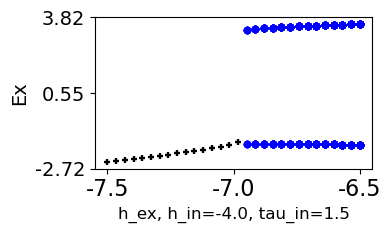

In [136]:
# Plot
fig, ax = plot_bifdiagram(results_min_f, results_max_f, 
                          results_min_b, results_max_b, par_set)

if par_max < par_min:
    
    direct = '_back.png'
    
else:
    
    direct = '_forw.png'

ax.set_xlabel('h_ex, h_in=' + str(h_in_0) + ', tau_in=' + str(pars[1]), fontsize=12)


if pars[1] == 1:

    ax.vlines(-1.855, -2.8, 3.92, 'gray', linestyles='dashed', linewidth=0.8)


elif pars[1] == 2:

    ax.vlines(-2.4, -2.8, 3.92, 'gray', linestyles='dashed', linewidth=0.8)
    ax.vlines(-1.85, -2.8, 3.92, 'gray', linestyles='dotted', linewidth=0.8)

    
title_chars = 'Figs/N=1/Fig_2Ab_Bifs_h_ex' + condition + '.png'
    
# fig.savefig(title_chars, dpi=300, format='png', bbox_inches='tight')

title_chars


SNIC: Scan of parameter $h_{ex}$ showing a bifurcation of two-variable model eq. (1). 
At $h_{ex} \approx -1.85$ (dashed vertical line), there is a saddle node bifurcation where the stable node of the excitatory variable (black crosses) collides with a saddle point (not shown). Black: stable fixed point. Blue: minima and maxima of a stable limit cycle.

Homoclinic: Scan of parameter $h_{ex}$ showing two bifurcations of two-variable model eq. (1). 
At $h_{ex} \approx -2.45$ (dashed vertical line), there is a homoclinic bifurcation of a limit cycle colliding with the stable manifold of a saddle point. 
At $h_{ex} \approx -1.85$ (dotted line), there is a saddle node bifurcation where the stable node represented by black circles collides with a saddle point (not shown). The region between these two bifurcations is a region of bistability where two attracting solutions coexist. Black: stable fixed point. Blue: stable limit cycle of which minima and maxima are displayed. Magenta [still missing]: limit cycle coexisting with stable steady state. 

Comment: Needs shading of oscillatory region, bistability, and bifurcation annotations in the figure. 


# Adjusted up to here

## Ramp to Seizure Onset

In [12]:
# Set Initial conditions:
y_ini = y_last


# Time array
time_stop = 70
sr        = 1000
time      = linspace(start=0, stop=time_stop, num=time_stop*sr)


# Driving
driving = linspace(0, 1, time.size)

if pars[1] == 1:

    driving_strength = 0.05

elif pars[1] == 2:
    
    driving_strength = 1.0


y = odeint(func=single_oscillator_plus_driving, y0=y_ini, t=time, 
              args=(h_ex_0, h_in_0, pars, sr, time_stop, driving, driving_strength), hmax=0.1)

print('End of run:', y.shape)
print('')


End of run: (70000, 2)



Figs/N=1/Onset_h_ex_Homoclinic.png


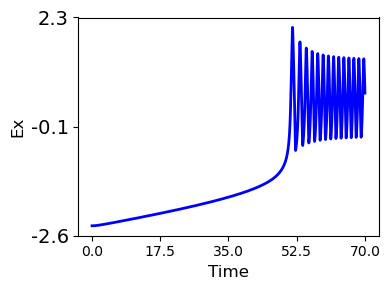

In [14]:
time_begin, time_end = 0, time_stop

fig, ax = plot_series(time, y, time_begin, time_end, sr)
    
title_chars = 'Figs/N=1/Onset_h_ex' + condition + '.png'

# fig.savefig(title_chars, dpi=300, format='png', bbox_inches='tight')

print(title_chars)

SNIC: Time series of the excitatory population in model eq. (1) while parameter $h_{ex}$ is slowly increased from values below $h_{ex} \approx -1.85$. When the saddle-node bifurcation is crossed, large amplitude oscillations with initially low frequency appear. The slow parameter shift results in a sudden change of the dynamics from stable to oscillatory. 

Homoclinic: Time series of the excitatory population in model eq. (1) while parameter $h_{ex}$ is slowly increased from values below $h_{ex} \approx -2.45$. When the saddle-node bifurcation is crossed, large amplitude oscillations appear. The slow parameter shift results in a sudden change of the dynamics from stable to oscillatory. 

## Scan of Initial Conditions

Complete



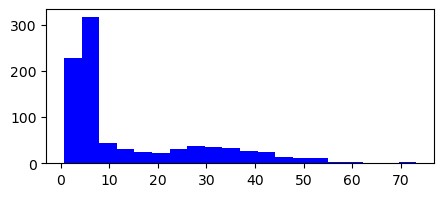

In [15]:
from itertools import product

# IC Scan Parameters
resolution = 30

if pars[1] == 1:

    y0_0_min, y0_0_max = -2,  2.5
    y1_0_min, y1_0_max =  3, -5

    h_ex = -1.86


elif pars[1] == 2:

    y0_0_min, y0_0_max = -1,  2
    y1_0_min, y1_0_max =  3, -9
    
    h_ex = -2.45


y0_0 = linspace(y0_0_min, y0_0_max, resolution)
y1_0 = linspace(y1_0_min, y1_0_max, resolution)

results = list()

for y_ini in product(y0_0, y1_0):

# Simulation
    y = odeint(func=single_oscillator, y0=y_ini, t=time, 
             args=(h_ex_0, h_in_0, pars), 
             hmax=0.1)
    
    results.append((sum(y[:, 0] - y_last[0])/sr, sum(y[:, 1] - y_last[1])/sr))

results_y0_matrix = asarray(results)[:, 0].reshape(resolution, resolution)
results_y1_matrix = asarray(results)[:, 1].reshape(resolution, resolution)

print('Complete')
print('')

fig, ax = subplots(figsize=(5, 2))

ax.hist(results_y0_matrix.ravel(), bins=20, color='b');

This histogram is included to estimate values of vmin, vmax in the next figure. 

Figs/N=1/Fig_2Bb_Basin_Homoclinic.png


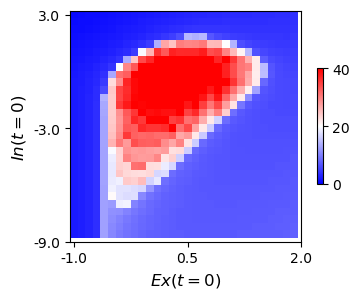

In [18]:
fig, ax = subplots(figsize=(4, 3))

if pars[1] == 1:

    vmin, vmax = 0, 16

elif pars[1] == 2:

    vmin, vmax = 0, 40
    

im1 = ax.imshow(results_y0_matrix.T, cmap='bwr', vmin=vmin, vmax=vmax)

ax.set_xlabel('$Ex(t=0)$', fontsize=12)
ax.set_ylabel('$In(t=0)$', fontsize=12)
ax.set_xticks(linspace(0, resolution, 3))
ax.set_xticklabels(linspace(y0_0_min, y0_0_max, 3))
ax.set_yticks(linspace(0, resolution, 3))
ax.set_yticklabels(linspace(y1_0_min, y1_0_max, 3))

fig.colorbar(im1, ax=ax, shrink=0.5, ticks=linspace(vmin, vmax, 3));
    
title_chars = 'Figs/N=1/Fig_2Bb_Basin' + condition + '.png'
    
# fig.savefig(title_chars, dpi=300, format='png', bbox_inches='tight')

print(title_chars)

SNIC: Scan of initial conditions in both variables of eq. (1) in the stable steady state with $h_{ex} = -1.86$. Colour-coded display of the deviation integral to estimate the whether the trajectory returns directly (via exponential decay) to the fixed (blue) or whether it follows an unusual path indicating an additional structure in state space (white and red). Due to the vicinity of the SNIC bifurcation in $h_{ex}$, the red spiral shape reflects in its outer section the "ghost" of the nearby (in parameter space) limit cycle. The inner spiralling part reflects a coexisting unstable focus. 

Homoclinic: Scan of initial conditions in both variables of eq. (1) in the monostable state with $h_{ex} = -2.5$. Colour-coded display of the deviation integral as in the SNIC case. Due to the vicinity of the homoclinic bifurcation, the red area reflects the "ghost" of the nearby (in parameter space) limit cycle. 

## Pulse Perturbation Parameter 2D Scan

In [19]:
y = odeint(func=single_oscillator, y0=y_ini, t=time, 
          args=(h_ex_0, h_in_0, pars), 
          hmax=0.1)

y_last = y[-1, :]

h_ex_0

-2.45

COMPLETE
 


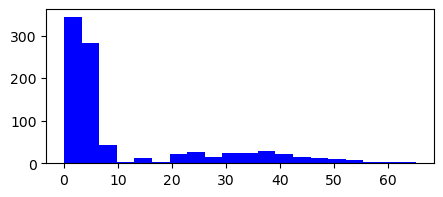

In [20]:
# Initial conditions y_last

time_stop_pert = 60
sr             = 1000
time           = linspace(start=0, stop=time_stop_pert, num=time_stop_pert*sr)

resolution = 30

if pars[1] == 1:

    pulse_width_min, pulse_width_max = 0.001, 3
    pulse_ampli_min, pulse_ampli_max = 0.3, 0.0001

elif pars[1] == 2:

    pulse_width_min, pulse_width_max = 0.001, 12
    pulse_ampli_min, pulse_ampli_max = 5, 0.0001


pulse_width = linspace(pulse_width_min, pulse_width_max, resolution)
pulse_ampli = linspace(pulse_ampli_min, pulse_ampli_max, resolution)

pulse_period = time_stop_pert

results_pert = list()

for pulse in product(pulse_width, pulse_ampli):

    h_ex_p = h_ex_0 + pulse[1]*ss.rect(mod(time, pulse_period)-pulse_period/2+pulse[0]/2, pulse[0])

    y = odeint(func=single_oscillator_pert, y0=y_last, t=time, args=(h_ex_p, h_in_0, pars, sr, time_stop_pert),
              hmax=0.1)

    results_pert.append((sum(y[time_stop_pert*sr//2:, 0] - y_last[0])/sr, 
                         sum(y[time_stop_pert*sr//2:, 1] - y_last[1])/sr
                     ))

results_pert_y0_matrix = asarray(results_pert)[:, 0].reshape(resolution, resolution)
results_pert_y1_matrix = asarray(results_pert)[:, 1].reshape(resolution, resolution)

print('COMPLETE')
print(' ')

fig, ax = subplots(figsize=(5, 2))

ax.hist(results_pert_y0_matrix.ravel(), bins=20, color='b');

'Figs/N=1/Fig_2Cb_PulsePert_scan_Homoclinic.png'

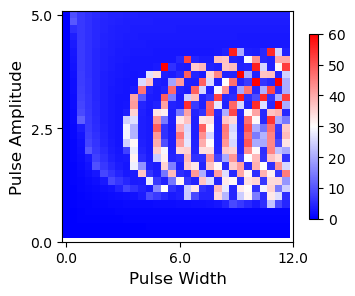

In [22]:
if pars[1] == 1:

    vmin, vmax = 0, 10

elif pars[1] == 2:

    vmin, vmax = 0, 60


fig, ax = subplots(figsize=(4, 3))

im1 = ax.imshow(results_pert_y0_matrix.T, cmap='bwr', vmin=vmin, vmax=vmax)

ax.set_xlabel('Pulse Width', fontsize=12)
ax.set_ylabel('Pulse Amplitude', fontsize=12)
ax.set_xticks(linspace(0, resolution, 3))
ax.set_xticklabels(around(linspace(pulse_width_min, pulse_width_max, 3), 2))
ax.set_yticks(linspace(0, resolution, 3))
ax.set_yticklabels(around(linspace(pulse_ampli_min, pulse_ampli_max, 3), 2))

fig.colorbar(im1, ax=ax, shrink=0.8);
    
title_chars = 'Figs/N=1/Fig_2Cb_PulsePert_scan' + condition + '.png'

# fig.savefig(title_chars, dpi=300, format='png', bbox_inches='tight')

title_chars

SNIC: Single pulse perturbation of model eq. (1) with a rectangular pulse. Shown is the
colour-coded integral of the return to the stable fixed point at $h_{ex} = -1.86$ as a function of pulse width and pulse amplitude. Dark red indicates abnormally long transients due to the trajectory being pushed into the region of the ghost of a limit cycle (c.f. previous figure). The boundary between the blue and the red region demonstrates a threshold of excitability. 

Homoclinic: Single pulse perturbation of model eq. (1) with a rectangular pulse. Shown is the colour-coded integral of the return to the stable fixed point at $h_{ex} = -2.45$ as a function of pulse width and pulse amplitude. Red shows abnormal (oscillatory) transients due to the trajectory being pushed into the region of the ghost of a limit cycle (c.f. previous figure).

'Figs/N=1/Fig_2Db_PulsePert_series_Homoclinic.png'

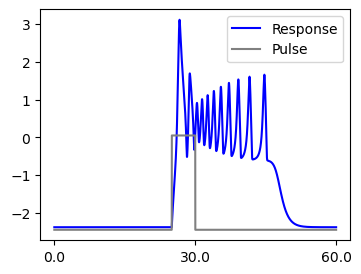

In [24]:
time_stop_pert = 60
sr             = 1000
time           = linspace(start=0, stop=time_stop_pert, num=time_stop_pert*sr)


if pars[1] == 1:

    pulse_width_series = 1.5
    pulse_ampli_series = 0.13

elif pars[1] == 2:

    pulse_width_series = 5
    pulse_ampli_series = 2.5


pulse_period = time_stop_pert

results_pert = list()

h_ex_p = h_ex_0 + pulse_ampli_series*ss.rect(mod(time, pulse_period)-pulse_period/2+pulse_width_series/2, pulse_width_series)

y_series = odeint(func=single_oscillator_pert, y0=y_last, t=time, args=(h_ex_p, h_in_0, pars, sr, time_stop_pert), hmax=0.1)

fig, ax = subplots(figsize=(4,3))

ax.plot(y_series[:, 0], label='Response', c='b');
ax.plot(h_ex_p, label='Pulse', color='gray');
ax.legend()

ax.set_xticks(linspace(0, time_stop_pert*sr, 3));
ax.set_xticklabels(linspace(0, time_stop_pert, 3));

title_chars = 'Figs/N=1/Fig_2Db_PulsePert_series' + condition + '.png'

# fig.savefig(title_chars, dpi=300, format='png', bbox_inches='tight')

title_chars

SNIC: Time series of a suprathreshold response of model eq. (1) to a pulse perturbation stopping at t=30. The pulse parameters were chosen from the red region in the above parameter scan. 

Homoclinic: Time series of a suprathreshold response of model eq. (1) to a pulse perturbation stopping at t=30. The oscillatory response has increasig amplitude and frequency slowing before it self-terminates.


## Periodic Perturbation Frequency Scan

In [25]:
if pars[1] == 1:
    
    h_ex_set = [-1.86, -1.96]


elif pars[1] == 2:

    h_ex_set = [-2.45, -2.65]


y_in_sets = list()

for h_ex in h_ex_set:

    y = odeint(func=single_oscillator, y0=y_last, t=time, 
              args=(h_ex, h_in_0, pars), 
              hmax=0.1)
    
    y_in_sets.append(y[-1, :])

y_in_sets

[array([ -2.38237655, -13.83094137]), array([ -2.60668977, -13.89172443])]

In [26]:
# Bifurcation parameter set
steps = 30

if pars[1] == 1:

    freq_min, freq_max = 0.7, 0.9
    
    pulse_wid = 0.1
    
    pulse_amp = 0.1


elif pars[1] == 2:

    freq_min, freq_max = 0.1, 0.8
    
    pulse_wid = 1.0
    
    pulse_amp = 1.5
    

freq_set = linspace(freq_min, freq_max, steps)

# Time array
time_stop_freq = 100
sr             = 1000
time           = linspace(start=0, stop=time_stop_freq, num=time_stop_freq*sr)

rows = time.size



results = list()

for step, h_ex in enumerate(h_ex_set):
    
    results_min_f      = dict()
    results_min_inds_f = dict()
    results_max_f      = dict()
    results_max_inds_f = dict()
    
    # Simulation "forward"
    for freq in freq_set:
        
        pulse = pulse_amp*ss.rect(mod(time, 1/freq)-(1/freq)/2-pulse_wid/2, pulse_wid)

        h_ex_p = h_ex + pulse

        y_pert = odeint(func=single_oscillator_pert, y0=y_in_sets[step], t=time, 
                        args=(h_ex_p, h_in_0, pars, sr, time_stop_freq), 
                        hmax=0.1)

        for num, series in enumerate(y_pert[rows//2:,:-1:2].T):
                    
            if var(series) < 0.0001:
        
                if num not in results_min_f:
                    
                    results_min_f[num]      = [series[-1]]
                    results_min_inds_f[num] = [0]    
                   
                else:
                    results_min_f[num].append(series[-1])
                    results_min_inds_f[num].append(0)    
    
                if num not in results_max_f:
                    
                    results_max_f[num]      = [series[-1]]
                    results_max_inds_f[num] = [0]    
                   
                else:
                    results_max_f[num].append(series[-1])
                    results_max_inds_f[num].append(0)    
    
            else:
                
                y_f_max_inds = find_peaks(series, distance=100)
                y_f_maxs     = series[y_f_max_inds[0]]
    
                y_f_min_inds = find_peaks(-series, distance=100)
                y_f_mins     = series[y_f_min_inds[0]]
    
                if num not in results_min_f:
    
                    results_min_f[num]      = [y_f_mins]
                    results_min_inds_f[num] = [y_f_min_inds]
                    
                    results_max_f[num]      = [y_f_maxs]
                    results_max_inds_f[num] = [y_f_max_inds]
    
                else:
    
                    results_min_f[num].append(y_f_mins)
                    results_min_inds_f[num].append(y_f_min_inds)
                    
                    results_max_f[num].append(y_f_maxs)
                    results_max_inds_f[num].append(y_f_max_inds)

    results.append((results_min_f, results_max_f))

print('')
print('Scan complete!')
print('')



Scan complete!



'Figs/N=1/Fig_2Eb_FreqPert_scan_Homoclinic.png'

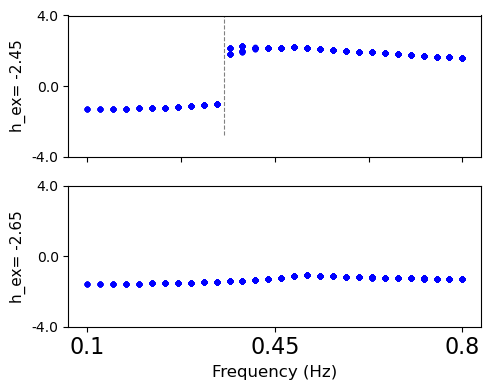

In [28]:
# Plot
fig, ax = plot_bifdiagram_freq(results, freq_set)

for value in arange(len(h_ex_set)):

    ax[value].set_ylabel('h_ex= ' + str(h_ex_set[value]), fontsize=11)
    
ax[-1].set_xlabel('Frequency (Hz)', fontsize=12);

if pars[1] == 1:

    ax[0].vlines(0.803, -4, 3.92, 'gray', linestyles='dashed', linewidth=0.8)


elif pars[1] == 2:

    ax[0].vlines(0.355, -2.8, 5.92, 'gray', linestyles='dashed', linewidth=0.8)

    

title_chars = 'Figs/N=1/Fig_2Eb_FreqPert_scan' + condition + '.png'

# fig.savefig(title_chars, dpi=300, format='png', bbox_inches='tight')

title_chars

SNIC: Periodic pulse perturbation of model eq. (1) with a periodic rectangular pulse train at $h_{ex} = -1.86$ (top) and $h_{ex} = -1.96$ (bottom) as a function of perturbation frequency.  Shown are the maxima of the oscillatory solutions. Negative maxima indicate that the response stays close to the stable node (bottom and left part of top figure). Positive maxima for frequencies above $freq \approx 0.803$ in top figure show suprathreshold responses where continued large oscillations are induced by the pulse train. 

Homoclinic: Periodic pulse perturbation of model eq. (1) with a rectangular pulse train at $h_{ex} = -2.45$ (top) and $h_{ex} = -2.65$ (bottom). Shown are the maxima of the oscillatory solutions. Negative maxima in the bottom figure show that the responses stay close to the stable node. Positive maxima for large frequencies in the top figure for frequencies above 0.3 Hz (gray vertical line) show suprathreshold responses where the trajectory enters the region of the limit cycle "ghost".

## Single frequency time series

'Figs/N=1/Fig_2Eb_FreqPert_series_Homoclinic.png'

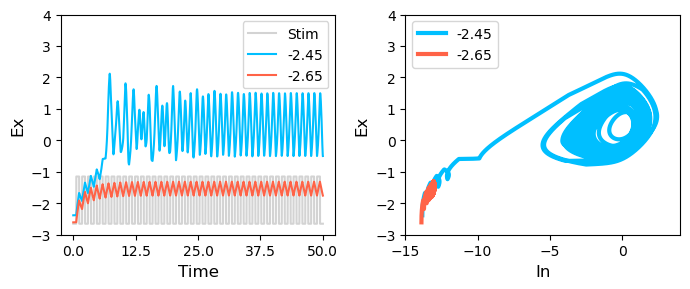

In [31]:

if pars[1] == 1:

    freq_single    = 0.85

    time_stop_freq = 200

elif pars[1] == 2:

    freq_single    = 0.85

    time_stop_freq = 50


sr             = 1000
time           = linspace(start=0, stop=time_stop_freq, num=time_stop_freq*sr)

rows = time.size

pulse = pulse_amp*ss.rect(mod(time, 1/freq_single)-(1/freq_single)/2-pulse_wid/2, pulse_wid)

colours = ['deepskyblue', 'tomato']

fig, ax = subplots(ncols=2, figsize=(7, 3))

ax[0].plot(h_ex_p, 'lightgray', label='Stim');

for index, h_ex_pick in enumerate(h_ex_set):

    h_ex_p = h_ex_pick + pulse

    y_pert = odeint(func=single_oscillator_pert, y0=y_in_sets[index], t=time, 
                        args=(h_ex_p, h_in_0, pars, sr, time_stop_freq), 
                        hmax=0.1)

    
    ax[0].plot(y_pert[:, 0], colours[index], label=h_ex_pick);

    ax[0].set_ylim(-3, 4)
    ax[0].set_xticks(linspace(0, time_stop_freq*sr, 5));
    ax[0].set_xticklabels(linspace(0, time_stop_freq, 5));
    ax[0].set_xlabel('Time', fontsize=12);
    ax[0].set_ylabel('Ex', fontsize=12);

    ax[1].plot(y_pert[:, 1], y_pert[:, 0], colours[index], label=h_ex_pick, linewidth=3);
    ax[1].set_xlim(-15, 4)
    ax[1].set_ylim(-3, 4)
    ax[1].set_xlabel('In', fontsize=12);
    ax[1].set_ylabel('Ex', fontsize=12);

ax[1].legend(loc='upper left')
ax[0].legend(loc='upper right')


fig.tight_layout()



title_chars = 'Figs/N=1/Fig_2Eb_FreqPert_series' + condition + '.png'

# fig.savefig(title_chars, dpi=300, format='png', bbox_inches='tight')

title_chars


SNIC: Time series (left) and state space trajectory (right) of responses of model eq. (1) to periodic pulse perturbation at frequency $freq = 0.85$. Other conditions as in the previous figure. Blue: parameter $h_{ex}$ close to the bifurcation point leads to suprathreshold oscillations with large amplitude. Red: parameter $h_{ex}$ farther away from the bifurcation point resulting in small amplitude oscillations in the vicinity of the stable fixed point. 

Homoclinic: Time series (left) and state space trajectory (right) of responses of model eq. (1) to periodic pulse perturbation at frequency $freq = 0.85$. Blue: parameter $h_{ex}$ close to the bifurcation point leads to suprathreshold oscillations with large amplitude. Red: parameter $h_{ex}$ farther away from the bifurcation point resulting in small amplitude oscillations around the stable fixed point. 